In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import  shutil
from sklearn.model_selection import train_test_split

# Source folder with combined images by class
source_dir = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"

# Output folders for clean splits
train_dir = "/kaggle/working/train_images"
test_dir = "/kaggle/working/test_images"

# Create output folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [5]:
# Loop through each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    files = os.listdir(class_path)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Create class folders inside train/test directories
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Copy training files
    for fname in train_files:
        src = os.path.join(class_path, fname)
        dst = os.path.join(train_class_dir, fname)
        shutil.copyfile(src, dst)

    # Copy testing files
    for fname in test_files:
        src = os.path.join(class_path, fname)
        dst = os.path.join(test_class_dir, fname)
        shutil.copyfile(src, dst)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training + Validation from /train_images (with validation_split)
train_val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.08)

train_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_val_datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator from completely separate folder
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180,180),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

2025-06-30 13:13:03.428115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751289183.691665      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751289183.767238      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 32385 images belonging to 4 classes.
Found 2815 images belonging to 4 classes.
Found 8800 images belonging to 4 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers

In [18]:
model = Sequential()

# 1st Conv Block
model.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu",kernel_regularizer=regularizers.l2(0.001),input_shape=(180,180,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# 3rd Conv Block
model.add(Conv2D(64, kernel_size=(3,3), activation="relu",kernel_regularizer=regularizers.l2(0.001),padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

# 3rd Conv Block
model.add(Conv2D(128, kernel_size=(3,3), activation="relu",kernel_regularizer=regularizers.l2(0.001),padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3,3), activation="relu",kernel_regularizer=regularizers.l2(0.001), padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3,3), activation="relu",kernel_regularizer=regularizers.l2(0.001), padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))



# Fully Connected
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu",kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu",kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(4, activation="softmax"))  # 4 output classes

# Compile model
model.compile(optimizer= Adam(learning_rate=0.0007),
              loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=["accuracy"])

# Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 11, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 256)           │              

 Total params: 4,393,156 (16.76 MB)

 Trainable params: 4,390,660 (16.75 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True),
ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience= 3, verbose=1),
ModelCheckpoint(filepath='/kaggle/working/best_model.h5',monitor='val_accuracy',save_best_only=True,mode='max',verbose=0
)]


In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs= 30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 88s 134ms/step - accuracy: 0.3700 - loss: 3.3903 - val_accuracy: 0.2913 - val_loss: 3.3557 - learning_rate: 7.0000e-04
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.5745 - loss: 2.6237 - val_accuracy: 0.6291 - val_loss: 2.1985 - learning_rate: 7.0000e-04
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.6775 - loss: 2.0231 - val_accuracy: 0.6657 - val_loss: 1.8131 - learning_rate: 7.0000e-04
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.7461 - loss: 1.6360 - val_accuracy: 0.7829 - val_loss: 1.4495 - learning_rate: 7.0000e-04
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.7820 - loss: 1.4460 - val_accuracy: 0.7744 - val_loss: 1.4228 - learning_rate: 7.0000e-04
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.8199 - loss: 1.3526 - val_accuracy: 0.7726 - val_loss: 1.4435 - learning_rate: 7.0000e-04
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/st

Plot of accuracy and val_accuracy of the model per epoch :



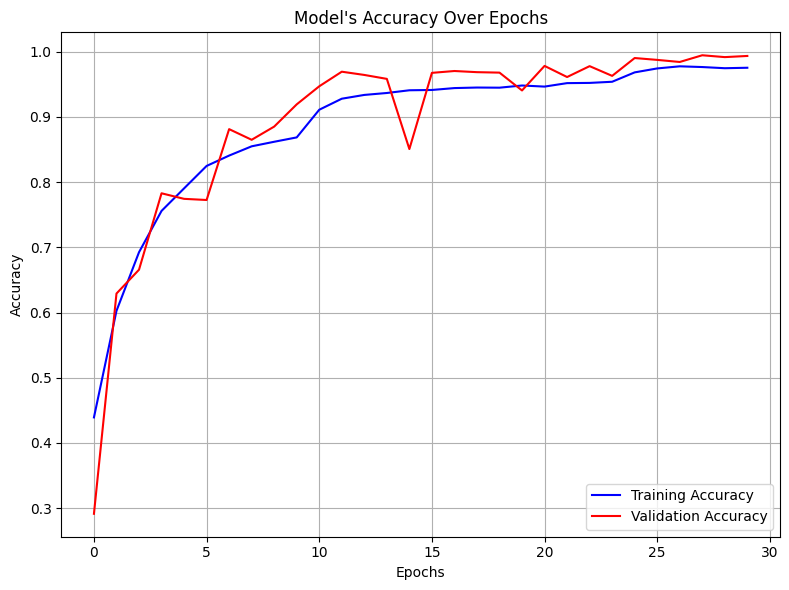

In [21]:
import matplotlib.pyplot as plt
print("Plot of accuracy and val_accuracy of the model per epoch :\n")
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", color="b")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="r")
plt.title("Model's Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Plot of loss and val_loss of the model per epoch :



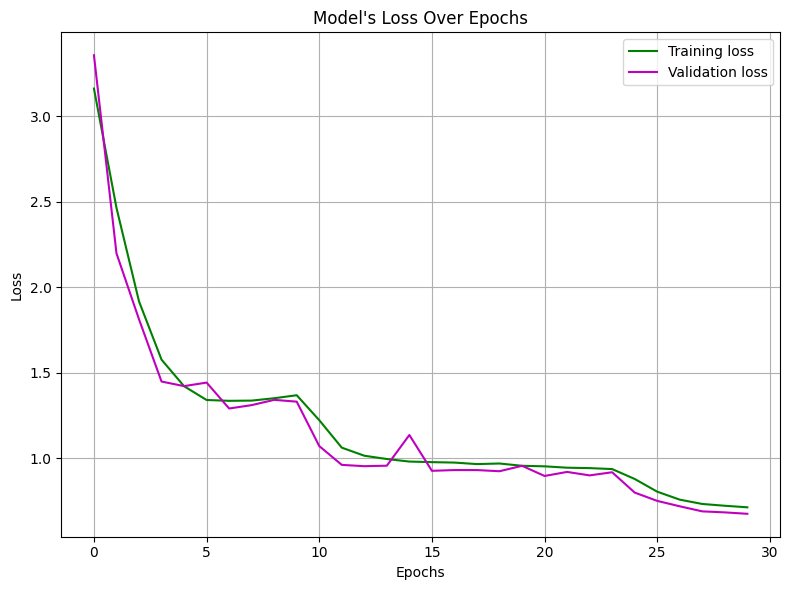

In [22]:
print("Plot of loss and val_loss of the model per epoch :\n")
plt.figure(figsize=(8,6))
plt.plot(history.history["loss"], label="Training loss", color="g")
plt.plot(history.history["val_loss"], label="Validation loss", color="m")
plt.title("Model's Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import classification_report,accuracy_score
# Evaluate accuracy and loss
loss_test, accuracy_test = model.evaluate(test_generator)
print(f"\n Evaluation Results on Test Data : Loss = {loss_test:.4f}, Accuracy = {accuracy_test:.4f}\n")

y_pred_probs_test = model.predict(test_generator)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)
y_true_test = test_generator.classes
class_labels_test = list(test_generator.class_indices.keys())
print("\nAcuracy on test data : ",accuracy_score(y_true_test,y_pred_test))
print("\nClassification Report on Test data :\n")
print(classification_report(y_true_test, y_pred_test, target_names=class_labels_test))

69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.9961 - loss: 0.6699

 Evaluation Results on Test Data : Loss = 0.6773, Accuracy = 0.9919

69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step

Acuracy on test data :  0.9919318181818182

Classification Report on Test data :

                  precision    recall  f1-score   support

    MildDemented       0.98      1.00      0.99      2000
ModerateDemented       1.00      1.00      1.00      2000
     NonDemented       1.00      0.99      0.99      2560
VeryMildDemented       0.99      0.99      0.99      2240

        accuracy                           0.99      8800
       macro avg       0.99      0.99      0.99      8800
    weighted avg       0.99      0.99      0.99      8800



In [24]:
# Evaluate accuracy and loss
loss_train, accuracy_train = model.evaluate(train_generator)
print(f"\n Evaluation Results on Train Data : Loss = {loss_train:.4f}, Accuracy = {accuracy_train:.4f}")

y_pred_probs_train = model.predict(train_generator)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)
y_true_train = train_generator.classes
class_labels_train = list(train_generator.class_indices.keys())

507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.9991 - loss: 0.6643

 Evaluation Results on Train Data : Loss = 0.6645, Accuracy = 0.9988
507/507 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step


<Figure size 1000x800 with 0 Axes>

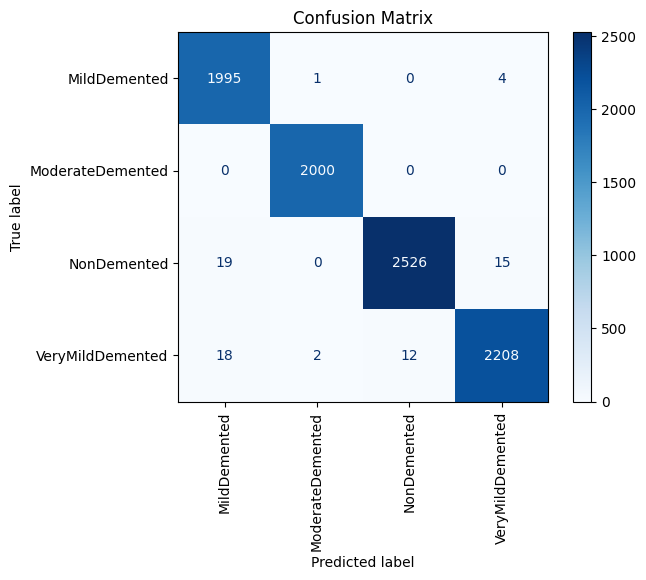

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels_test)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

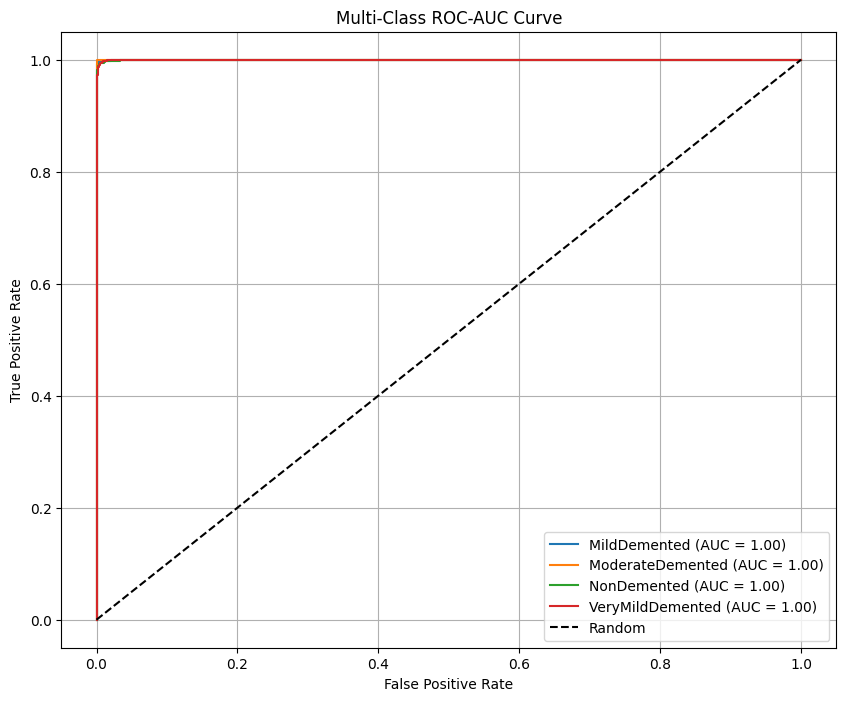

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Binarize the true labels
y_true_bin = label_binarize(y_true_test, classes=range(len(class_labels_test)))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_labels_test)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels_test[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()